# Model Monitoring KPI Example
This notebook demonstrates how to use the `model_monitoring` module to define and analyze Key Performance Indicators (KPIs) across different data segments.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from model_monitoring import (
    SegmentCategorical,
    SegmentCustom,
)
from model_monitoring.global_analyses import GlobalAnalysisDataBuilder

## 1. Generate Synthetic Data

First, we'll create a synthetic dataset. This dataset mimics a typical insurance scenario with multiple coverages, predictions (risk premiums), and observed outcomes (targets/claims). The data is saved to a parquet file.

In [2]:
# --- Create a Synthetic Dataset ---
np.random.seed(42)
n_samples = 10000

# Create some numerical features
features = pd.DataFrame(
    {
        "age": np.random.randint(18, 70, n_samples),
        "income": np.random.gamma(2, 40000, n_samples),
        "credit_score": np.random.randint(300, 850, n_samples),
        "market_premium": np.random.uniform(0.1, 0.5, n_samples),
    }
)

# Create a categorical feature
features["region"] = np.random.choice(
    ["North", "South", "East", "West"], n_samples, p=[0.3, 0.2, 0.25, 0.25]
)

# --- Generate data for N=3 coverages in a wide format ---
N_coverages = 3
df = features.copy()

for i in range(N_coverages):
    cov_suffix = f"_{chr(65 + i)}"  # e.g., _A, _B, _C

    # --- Generate True Risk (rate for Poisson) ---
    true_risk_formula = (
        -4.0
        + (i * 0.1)
        + df["age"] / (20 + i * 2)
        - df["credit_score"] / (500 + i * 20)
        + df["income"] / 100000
    )
    true_risk_index = np.exp(true_risk_formula)

    # --- Generate a Slightly Incorrect Prediction ---
    prediction_formula = (
        -3.9
        + (i * 0.1)
        + df["age"] / (22 + i * 2)
        - df["credit_score"] / (550 + i * 20)
        + df["income"] / 110000
    )
    df[f"prediction{cov_suffix}"] = np.exp(prediction_formula)
    df[f"prediction{cov_suffix}_comp"] = np.exp(
        prediction_formula + 0.1 * +df["age"] / (22 + i * 2)
    )
    # --- Generate Target (claims) from the true risk ---
    df[f"target{cov_suffix}"] = np.random.poisson(true_risk_index)

# Add a single weight column
df["weight"] = 1.0

# Save to parquet
output_path = "../../data/segmentation_data_comp.parquet"
df.to_parquet(output_path)

print(f"Synthetic data generated and saved to {output_path}")
df.head()

Synthetic data generated and saved to ../../data/segmentation_data_comp.parquet


,age,income,credit_score,market_premium,region,prediction_A,prediction_A_comp,target_A,prediction_B,prediction_B_comp,target_B,prediction_C,prediction_C_comp,target_C,weight
0,56,31626.419807,693,0.295256,West,0.097585,0.125872,0,0.091178,0.115140,0,0.087754,0.108845,0,1.0
1,69,94350.676790,565,0.230289,East,0.393303,0.538192,0,0.346978,0.462553,1,0.317891,0.414508,0,1.0
2,46,34226.773664,803,0.112133,South,0.051926,0.064002,0,0.050744,0.061465,0,0.050761,0.060585,0,1.0
3,32,189107.488476,433,0.410269,North,0.220123,0.254587,0,0.221539,0.253137,0,0.226736,0.256432,1,1.0
4,60,32588.089714,325,0.305161,South,0.230528,0.302809,0,0.207231,0.266090,0,0.192646,0.242651,0,1.0


## 2. Configure the Analysis

Now, we set up the analysis by defining the coverages, segmentation strategies, and data treatments.

### Prediction & Target Mapping
We create a dictionary to map each coverage to its corresponding prediction, target, and weight columns.

In [3]:
pred_dict = {
    "A": {"sel_col": "weight", "pred_col": "prediction_A", "target_col": "target_A"},
    "B": {"sel_col": "weight", "pred_col": "prediction_B", "target_col": "target_B"},
    "C": {"sel_col": "weight", "pred_col": "prediction_C", "target_col": "target_C"},
}

### Segmentation Strategies
We define how to segment the data. We can create segments from categorical features or by binning numerical features.

In [4]:
segments = [
    # Segment for Age with custom bins
    SegmentCustom(
        seg_col="age",
        seg_name="age_group",
        bins=[18, 30, 45, 60, 75],
        bin_labels=["18-29", "30-44", "45-59", "60+"],
    ),
    # Segment for Income with 5 equal-width bins
    SegmentCustom(seg_col="income", seg_name="income_level", bins=5),
    # Segment for Region (each category is a segment)
    SegmentCategorical(seg_col="region", seg_name="region_segment"),
]
print(f"{len(segments)} segments defined.")

3 segments defined.


### Initialize Analysis and Apply Treatments
We initialize the `AnalysisDataBuilder` object, which orchestrates the data loading, treatment, and segmentation. Treatments are applied to the data, such as iso resources scaling of predictions or aggregating totals.

In [5]:
# Define a configuration dict for global analysis (e.g., Lorenz curve)
# We'll compare two prediction columns vs. a target, using the same global weight
func_dict_lorenz = {
    "models": {
        "Base model": {"pred_col": "prediction_A", "name": "model A"},
        "Comp model": {"pred_col": "prediction_A_comp", "name": "model A comp"},
    },
    "observation": {
        "target_col": "target_A",
    },
    "weight_col": "weight",
    "n_bins": 20,
    "ascending": True,
}

func_dict_calibration = {
    "models": {
        "Base model": {"pred_col": "prediction_A", "name": "model A"},
        "Comp model": {"pred_col": "prediction_A_comp", "name": "model A comp"},
    },
    "observation": {
        "target_col": "target_A",
    },
    "weight_col": "weight",
    "n_bins": 20,
}


func_dict_prediction = {
    "models": {
        "Base model": {"pred_col": "prediction_A", "name": "model A"},
        "Comp model": {"pred_col": "prediction_A_comp", "name": "model A comp"},
    },
    "weight_col": "weight",
    "n_bins": 40,
    "yscale": "log",
    "xscale": "log",
}

In [ ]:
# Initialize GlobalAnalysisDataBuilder with the data path
lr_analysis = GlobalAnalysisDataBuilder(
    data=output_path, extra_cols=[]
)  # extra_cols optional here

# Register analyses
lr_analysis.add_analysis("lorenz_curve", func_dict_lorenz)
lr_analysis.add_analysis("calibration_curve", func_dict_calibration)
lr_analysis.add_analysis("prediction_analysis", func_dict_prediction)
# Load data
lr_analysis.load_data()

# Calculate all
lr_analysis.calculate()

# Collect analysis objects (now plotting expects analysis instances)
analyses_objs = lr_analysis.get_analyses_objects()

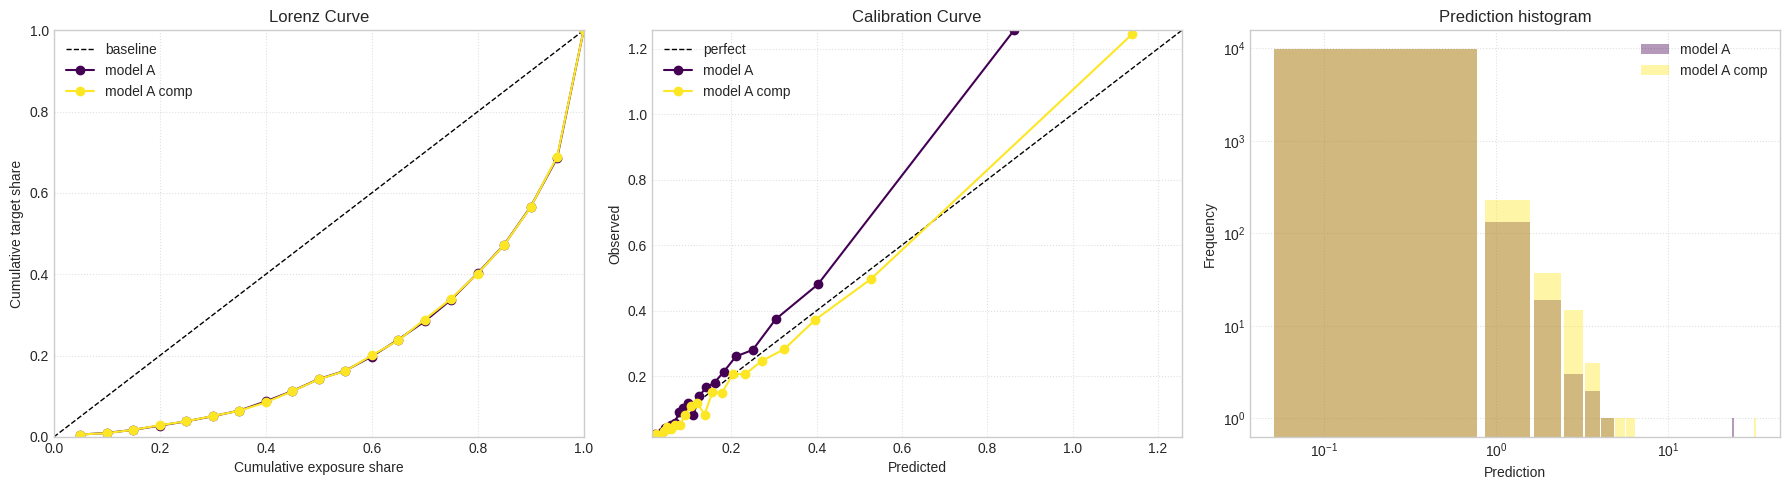

In [7]:
# Define the panels for the plot
report_panels = [
    {
        "title": "Lorenz Curve",
        "type": "lorenz_curve",
    },
    {
        "title": "Calibration Curve",
        "type": "calibration_curve",
    },
    {
        "title": "Prediction histogram",
        "type": "prediction_analysis",
        "xscale": "log",
        "yscale": "log",
    },
]

from model_monitoring.plotting import plot_global_statistics

plot_global_statistics(analyses_objs, panel_configs=report_panels, show=True)